# Thematic differences (Hungary)

DHH23 Parliament group

Author: Pontus H.

In [380]:
# Set the theme here
THEME = 'healthcare_HU'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'
# Set the output path for the model
MODEL_PATH = '../data/models/'

In [381]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

In [382]:
# Hungarian stopwords
with open('../data/stopwords-hu.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

Set up the BERTopic pipeline

In [383]:
df = pd.read_csv(f'../data/{THEME}.csv')
import numpy as np
HDBSCAN_MIN_CLUSTER_SIZE = int(np.sqrt(len(df)))

In [384]:
# Parameters
# PARAMETERS FOR EU: MIN_CLUSTER_SIZE = 50, MIN_SAMPLES = 1, CLUSTER_SELECTION_EPSILON = 0.1
# PARAMETERS FOR WAR: MIN_CLUSTER_SIZE = 20, MIN_SAMPLES = 1, CLUSTER_SELECTION_EPSILON = 0.05
# PARAMETERS FOR HEALTHCARE: MIN_CLUSTER_SIZE = 20, MIN_SAMPLES = 1, CLUSTER_SELECTION_EPSILON = 0.05
# HDBSCAN_MIN_CLUSTER_SIZE = 20
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0
OUTLIER_THRESHOLD = 0.1

# Step 1 - Extract embeddings
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # English
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') # Other languages

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
# vectorizer_model = CountVectorizer(stop_words="english") # English
vectorizer_model = CountVectorizer(stop_words=stopwords) # Other languages

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  #nr_topics="25",
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [385]:
df['Speaker_party'].describe()

count             4530
unique              19
top       KNDP-frakció
freq              1026
Name: Speaker_party, dtype: object

In [386]:
# Reference running time for this cell: 4min 00s
topics, probs = topic_model.fit_transform(df['speech'])


In [387]:
# Reduce outliers
# threshold was decreased from 0.1 to 0.05 for gender_HU
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=OUTLIER_THRESHOLD)


In [388]:
pd.Series(new_topics).value_counts()

 0    1352
 1    1329
 2     827
-1     417
 3     318
 4     129
 5     117
 6      94
dtype: int64

In [389]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [390]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [391]:
# Number of topics
print(f"Number of topics: {len(pd.Series(new_topics).unique())}")

Number of topics: 8


In [392]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

 5    1229
 3    1112
-1     945
 4     745
 6     247
 0     114
 2     113
 1      78
dtype: int64

In [393]:
topic_model.visualize_topics()

Topics over time

In [394]:
# Reference running time for this cell: 2min 30s

# topics_over_time = topic_model.topics_over_time(df['speech'], df['Date'].to_list(), nr_bins=20)

In [395]:
# Save the topics_over_time dataframe to a feather file
#topics_over_time.to_feather("../data/topics_over_time.feather")

In [396]:
# topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)
#topic_model.visualize_topics_over_time(topics_over_time, topics=[0,18])


What is interesting about the plot above is that the keywords associated with the topic CHANGE over time! Maybe this could be a useful pointer towards further exploration.

In [397]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
# Create the output directory if it does not exist
import os
if not os.path.exists(f"{OUTPUT_PATH}{THEME}"):
    os.makedirs(f"{OUTPUT_PATH}{THEME}")
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}/{THEME}_topic_keywords.png")
topic_word_scores

# Word Clouds

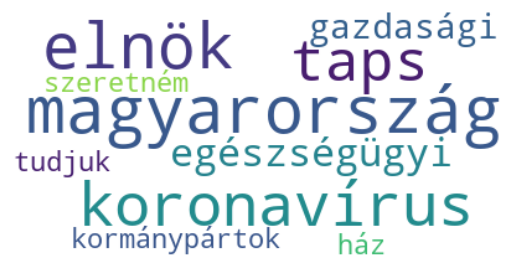

In [398]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [399]:
# topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [400]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
# get_keywords(0)

In [401]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Drop speeches with no party
speech_topic_party = speech_topic_party.dropna()
# Set the party name to 'Fidesz-KDNP' if the name contains Fidesz-frakció,  KNDP-frakció or Fidesz
speech_topic_party.loc[speech_topic_party['party'].str.contains('Fidesz-frakció|KNDP-frakció|Fidesz'), 'party'] = 'Fidesz-KDNP'
# Set the party name to 'Opposition' if the name contains MSZP or MSZP-frakció
speech_topic_party.loc[speech_topic_party['party'].str.contains('MSZP|MSZP-frakció'), 'party'] = 'Opposition'
# Set the party name to 'OTHER' if the party name does not contain 'Fidesz-KDNP' or 'Opposition'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('Fidesz-KDNP|Opposition'), 'party'] = 'OTHER'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
#speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,664,505,159
1,622,453,250
2,315,340,156
3,105,145,61
4,52,67,10
5,43,65,8
6,32,41,20


In [402]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,36.2,31.2,23.9
1,33.9,28.0,37.7
2,17.2,21.0,23.5
3,5.7,9.0,9.2
4,2.8,4.1,1.5
5,2.3,4.0,1.2
6,1.7,2.5,3.0


In [403]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
# percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,Fidesz-KDNP,OTHER,Opposition,keywords
topic,,,,
0,36.2,31.2,23.9,"[magyarország, elnök, koronavírus, taps, egész..."
1,33.9,28.0,37.7,"[tisztelt, milliárd, elnök, orvos, taps, dolgo..."
2,17.2,21.0,23.5,"[tisztelt, törvény, államtitkár, emberek, fog,..."
3,5.7,9.0,9.2,"[magyar, 2017, jövő, költségvetésben, családok..."
4,2.8,4.1,1.5,"[környezetvédelmi, műanyag, európai, program, ..."
5,2.3,4.0,1.2,"[önkormányzat, élők, tisztelt, elnök, fontos, ..."
6,1.7,2.5,3.0,"[minimálbér, szociális, 2010, korhatár, magyar..."


In [404]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
# percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,Fidesz-KDNP,OTHER,Opposition
0,0,50.0,38.0,12.0
1,1,46.9,34.2,18.9
2,2,38.8,41.9,19.2
3,3,33.8,46.6,19.6
4,4,40.3,51.9,7.8
5,5,37.1,56.0,6.9
6,6,34.4,44.1,21.5


Calculate mean sentiment for each topic per party

In [405]:
# sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'speech_id': df['ID'], 'party': df['Speaker_party'], 'sentiment': df['sentiment'], 'speech_date': df['Date'], 'prob': list(probs), 'speech': df['speech']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Drop speeches with no party
sentiment_topic_party = sentiment_topic_party.dropna()
# Set the party name to 'Fidesz-KDNP' if the name contains Fidesz-frakció,  KNDP-frakció or Fidesz
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('Fidesz-frakció|KNDP-frakció|Fidesz'), 'party'] = 'Fidesz-KDNP'
# Set the party name to 'Opposition' if the name contains MSZP or MSZP-frakció
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('MSZP|MSZP-frakció'), 'party'] = 'Opposition'
# Set the party name to 'OTHER' if the party name does not contain 'Fidesz-KDNP' or 'Opposition'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('Fidesz-KDNP|Opposition'), 'party'] = 'OTHER'
# Create a new dataframe with the relevant speeches and remove
relevant_speeches = sentiment_topic_party.copy()
sentiment_topic_party.drop(columns=['speech', 'speech_date', 'prob'], inplace=True)
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
# sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,-0.16,-0.45,-0.53
1,-0.27,-0.54,-0.58
2,-0.27,-0.45,-0.47
3,0.10,-0.45,-0.49
4,0.16,-0.57,-0.59
5,0.25,-0.40,-0.13
6,-0.40,-0.51,-0.40


In [406]:
# Save the topic model
topic_model.save(f"{MODEL_PATH}{THEME}_topic_model.bin")

In [407]:
def get_top_3(topic_id, party_name):
    speeches_for_topic_0_con = relevant_speeches[(relevant_speeches['party'] == party_name) & (relevant_speeches['topic'] == topic_id)]
    speeches_for_topic_0_con['prob'] = speeches_for_topic_0_con['prob'].apply(lambda x: x[topic_id])
    speeches_for_topic_0_con = speeches_for_topic_0_con.sort_values(by='sentiment', ascending=False)
    most_positive = speeches_for_topic_0_con.head(3)
    most_negative = speeches_for_topic_0_con.tail(3)
    return most_positive.append(most_negative).drop_duplicates(subset=['speech_id'])

parties = ['Fidesz-KDNP', 'Opposition', 'OTHER']

max_topic = relevant_speeches['topic'].max()

representative_speeches = get_top_3(0, 'Fidesz-KDNP')
for party in parties[1:]:
    representative_speeches = representative_speeches.append(get_top_3(0, party))
for topic_id in range(1,max_topic+1):
    for party in parties:
        representative_speeches = representative_speeches.append(get_top_3(topic_id, party))

# Save the representative speeches to a csv and feather file. Use '"" as the quotechar to avoid issues with the speech text
representative_speeches.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.csv', quotechar='"', index=False)
representative_speeches.reset_index().to_feather(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.feather')
representative_speeches

,topic,speech_id,party,sentiment,speech_date,prob,speech
887,0,u2021-06-07-23,Fidesz-KDNP,0.989258,2021-06-07,0.996771,Köszönöm szépen a szót. Tisztelt Elnök Úr! Tis...
1978,0,u2020-04-14-41,Fidesz-KDNP,0.951660,2020-04-14,0.741509,Köszönöm szépen a szót. Tisztelt Elnök Úr! Tis...
2741,0,u2020-07-01-29,Fidesz-KDNP,0.947754,2020-07-01,0.675557,Tisztelt Elnök Úr! Tisztelt Ház! Magyarország ...
3820,0,u2018-11-19-31,Fidesz-KDNP,-1.000000,2018-11-19,0.184820,"Köszönöm szépen a szót, elnök úr. Tisztelt Ale..."
515,0,u2021-04-12-167,Fidesz-KDNP,-1.000000,2021-04-12,0.997721,"Köszönöm a szót, elnök úr. Valóban felháborító..."
...,...,...,...,...,...,...,...
70,6,u2017-09-19-58,OTHER,0.391113,2017-09-19,0.179648,"Köszönöm a szót, elnök úr. Tisztelt Képviselőt..."
3614,6,u2016-11-29-135,OTHER,0.368164,2016-11-29,0.997156,"Köszönöm a szót, elnök úr. Tisztelt Ház! Az LM..."
395,6,u2017-10-02-135,OTHER,-0.937500,2017-10-02,0.996346,Köszönöm szépen a szót. Tisztelt Államtitkár Ú...
2418,6,u2020-04-06-7,OTHER,-0.973145,2020-04-06,1.000000,"Miniszter úr, én nem csodálkozom azon, hogy a ..."


In [408]:
# Create a new dataframe from percentages, percentages_per_row and sentiment_topic_party
concatenated_results = pd.concat([percentages, percentages_per_row, sentiment_topic_party], axis=1)
# Rename the columns to make it easier to understand
concatenated_results.columns = ['pf.Fidesz-KDNP', 'pf.OTHER', 'pf.Opposition', 'keywords', 'tc.Fidesz-KDNP', 'tc.OTHER', 'tc.Opposition', 's.Fidesz-KDNP', 's.OTHER', 's.Opposition']
# Reorder the columns
concatenated_results = concatenated_results[['keywords', 'tc.Fidesz-KDNP', 'tc.Opposition', 'tc.OTHER', 'pf.Fidesz-KDNP', 'pf.Opposition', 'pf.OTHER', 's.Fidesz-KDNP', 's.Opposition', 's.OTHER']]
# Save the results to a csv
concatenated_results.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_results.csv')
concatenated_results

,keywords,tc.Fidesz-KDNP,tc.Opposition,tc.OTHER,pf.Fidesz-KDNP,pf.Opposition,pf.OTHER,s.Fidesz-KDNP,s.Opposition,s.OTHER
topic,,,,,,,,,,
0,"[magyarország, elnök, koronavírus, taps, egész...",50.0,12.0,38.0,36.2,23.9,31.2,-0.16,-0.53,-0.45
1,"[tisztelt, milliárd, elnök, orvos, taps, dolgo...",46.9,18.9,34.2,33.9,37.7,28.0,-0.27,-0.58,-0.54
2,"[tisztelt, törvény, államtitkár, emberek, fog,...",38.8,19.2,41.9,17.2,23.5,21.0,-0.27,-0.47,-0.45
3,"[magyar, 2017, jövő, költségvetésben, családok...",33.8,19.6,46.6,5.7,9.2,9.0,0.10,-0.49,-0.45
4,"[környezetvédelmi, műanyag, európai, program, ...",40.3,7.8,51.9,2.8,1.5,4.1,0.16,-0.59,-0.57
5,"[önkormányzat, élők, tisztelt, elnök, fontos, ...",37.1,6.9,56.0,2.3,1.2,4.0,0.25,-0.13,-0.40
6,"[minimálbér, szociális, 2010, korhatár, magyar...",34.4,21.5,44.1,1.7,3.0,2.5,-0.40,-0.40,-0.51
